In [21]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Rescaling
from keras import backend as K
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.layers import Dense, Activation, Dropout, Convolution2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, BatchNormalization, SeparableConv2D
import os
from PIL import Image
import matplotlib.image as mpimg
import numpy as np
import scipy.ndimage
from sklearn.metrics import f1_score
import cv2
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'


# Preprocessing

Found 160000 images belonging to 50 classes.
Found 32000 images belonging to 50 classes.
11.0


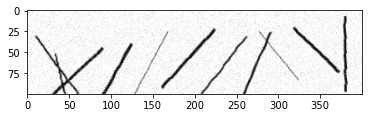

3.0


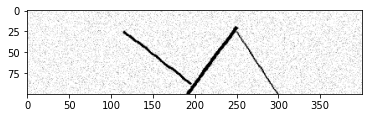

28.0


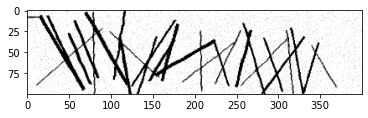

45.0


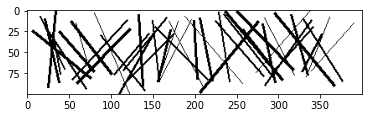

20.0


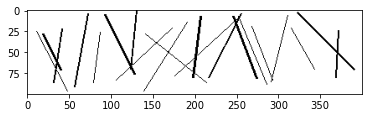

21.0


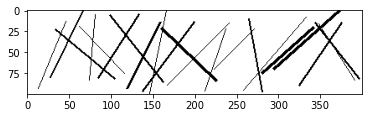

In [130]:
Batch_size = 32
num_classes = 50

def elastic_deformation(image, alpha, sigma):
    
    random_state = np.random.RandomState(None)
    shape = image.shape[:2]
    dx = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = scipy.ndimage.gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    x_deformed = x + dx
    y_deformed = y + dy
    deformed_image = np.zeros_like(image)
    for channel in range(image.shape[2]):
        deformed_image[:, :, channel] = scipy.ndimage.map_coordinates(image[:, :, channel], [y_deformed, x_deformed],order=1, mode='nearest')
    return deformed_image

def add_noise(x):
    noise = np.random.normal(loc=0, scale=17, size=x.shape)
    return x + noise

def apply_local_contrast(image, lower, upper, blur_sigma):
    contrast_mask = np.random.uniform(lower, upper, size=image.shape[:2])
    contrast_mask = cv2.GaussianBlur(contrast_mask, (0, 0), sigmaX=blur_sigma, sigmaY=blur_sigma)
    contrast_mask = np.repeat(contrast_mask[:, :, np.newaxis], 1, axis=2)
    return np.clip(image * contrast_mask, 0, 255)

def preproc(image):
    image = elastic_deformation(image,alpha=10,sigma=5)
    image = add_noise(image)
    image = tf.image.random_brightness(image, max_delta=0.4)
    image = tf.image.random_contrast(image, lower=0.2, upper=2)
    image = image / 255
    image = tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
    return image

train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    height_shift_range=0.10,
    rotation_range=5,
    fill_mode='nearest',
    preprocessing_function=preproc)

test_datagen = ImageDataGenerator(rescale=1. / 255)

training_data = train_datagen.flow_from_directory(
        'data',
        color_mode='grayscale',
        target_size=(100, 400),
        batch_size=Batch_size,
        class_mode='sparse')

test_data = test_datagen.flow_from_directory(
        'testdata',
        color_mode='grayscale',
        target_size=(100, 400),
        batch_size=Batch_size,
        class_mode='sparse')

x_batch, y_batch = next(training_data)
x_test, y_test = next(test_data)
for i in range(3):
    plt.imshow(x_batch[i],cmap='gray')
    print(y_batch[i])
    plt.show()
for i in range(3):
    plt.imshow(x_test[i],cmap='gray')
    print(y_test[i])
    plt.show()

# Model and training

In [131]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,decay_steps=2500,decay_rate=0.2)

reg = 0.002
# kernel_regularizer=keras.regularizers.l2(reg)

input_shape = (100,400,1)

model = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    
    Convolution2D(16, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    SeparableConv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    BatchNormalization(),    
    Dropout(0.5),
    
    Dense(1, activation='relu')
]) 



model.summary()
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mae',metrics=['mae'])
history = model.fit(training_data,validation_data=test_data,batch_size=Batch_size,epochs=15,callbacks=[early_stopping])


# tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2)

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 400, 16)      160       
                                                                 
 batch_normalization_124 (Ba  (None, 100, 400, 16)     64        
 tchNormalization)                                               
                                                                 
 dropout_100 (Dropout)       (None, 100, 400, 16)      0         
                                                                 
 separable_conv2d_81 (Separa  (None, 100, 400, 32)     688       
 bleConv2D)                                                      
                                                                 
 batch_normalization_125 (Ba  (None, 100, 400, 32)     128       
 tchNormalization)                                               
                                                     

KeyboardInterrupt: 

# Performance

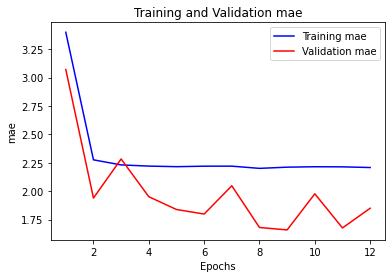

1/1 [==============================] - 3s 3s/step
Predicted number of line = [[45.81729]]
 24/500 [>.............................] - ETA: 1:42

KeyboardInterrupt: 

In [124]:
train_acc = history.history['mae']
val_acc = history.history['val_mae']




epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training mae')
plt.plot(epochs, val_acc, 'r', label='Validation mae')
plt.title('Training and Validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()


def get_img(path):
    img = Image.open(path)
    img = img.convert('L')
    img = img.resize((400,100))
    img = np.array(img)
    img = img/255.0
    img = np.expand_dims(img, axis=-1)  # add channel dimension
    img = np.expand_dims(img, axis=0)
    return img
def test(path):
    test_img = get_img(path)
    print(f'Predicted number of line = {(model.predict(test_img))}')

Images = ['realdata/tally5.jpg']

for image in Images:
    test(image);


n=5
predicted_labels = model.predict(test_data, verbose=1)
true_labels = test_data.classes


#HISTOGRAM

plt.hist(predicted_labels, bins=np.arange(num_classes + 1) - 0.5, edgecolor='black', rwidth=0.8)
plt.xlabel('Predicted Labels')
plt.ylabel('Frequency')
plt.title('Histogram of Model Predictions')
plt.xticks(range(num_classes))
plt.show()

plt.hist(true_labels, bins=np.arange(num_classes + 1) - 0.5, edgecolor='black', rwidth=0.8)
plt.xlabel('True Labels')
plt.ylabel('Frequency')
plt.title('Histogram of label distribution')
plt.xticks(range(num_classes))
plt.show()


# BEST VS WORST
n= 5
test_images = []
test_true_labels = []

for i in range(len(test_data)):
    x, y = test_data[i]
    test_images.extend(x)
    test_true_labels.extend(y)

test_images = np.array(test_images)
test_true_labels = np.array(test_true_labels)

# Calculate the absolute differences between true labels and predictions
abs_diffs = np.abs(test_true_labels - predicted_labels)

# Get the indices of the smallest absolute differences
best_indices = np.argsort(abs_diffs)[:n]
worst_indices = np.argsort(abs_diffs)[-n:]


print("Best predictions")
for index in best_indices:
    image = np.squeeze(test_images[index])
    plt.imshow(image, cmap='gray')
    plt.title(f"True label: {test_true_labels[index]}, Predicted label: {predicted_labels[index]}")
    plt.show()

print("Worst predictions")
for index in worst_indices:
    image = np.squeeze(test_images[index])
    plt.imshow(image, cmap='gray')
    plt.title(f"True label: {test_true_labels[index]}, Predicted label: {predicted_labels[index]}")
    plt.show()

# Hyper-parameter tuning

In [65]:
# !pip install keras-tuner --upgrade
from keras_tuner.tuners import RandomSearch,Hyperband, GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters


# hp.Float('dropout', min_value=0.2, max_value=0.5, step=0.1)),
# hp.Choice('conv', [8, 16, 32])
# hp.Int('dense', min_value=130, max_value=140, step=10)
#  hp.Choice('reg', [1e-2, 1e-4])

input_shape = (100,400,1)


def build_model(hp):
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hp.Choice('lr', [0.005, 0.001,0.0005,0.0001]),decay_steps=61250,decay_rate=0.1)

    regularization = hp.Choice('reg', [0.005, 0.0005,0.0001])
    input_shape = (100,400,1)
    model = keras.Sequential([
    keras.layers.InputLayer(input_shape=input_shape),
    
    SeparableConv2D(16, kernel_size=(5, 5), padding='same', kernel_regularizer=keras.regularizers.l2(regularization), activation='relu'),
    BatchNormalization(),
    SeparableConv2D(16, kernel_size=(3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(regularization), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    SeparableConv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(regularization), activation='relu'),
    BatchNormalization(),
    SeparableConv2D(32, kernel_size=(3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(regularization), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    
    SeparableConv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(regularization), activation='relu'),
    BatchNormalization(),
    SeparableConv2D(64, kernel_size=(3, 3), padding='same', kernel_regularizer=keras.regularizers.l2(regularization), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    
    Flatten(),
    
    Dense(30, kernel_regularizer=keras.regularizers.l2(regularization), activation='relu'),
    BatchNormalization(),    
    Dropout(0.5),
    
    Dense(1, activation='relu')])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='mae',metrics=['mse','mae'])
    return model

# Define the search strategy
tuner = Hyperband(
    build_model,
    objective='val_mse',
    max_epochs=6,
    directory='my_dir',
    project_name='tuning6',
)

train_steps_per_epoch = int(50*len(training_data) // Batch_size)
test_steps_per_epoch = int(50*len(test_data) // Batch_size)


early_stopping = EarlyStopping(monitor='val_mse', patience=2)

tuner.search(training_data,validation_data=test_data,epochs=6,callbacks=[early_stopping])
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]



Trial 5 Complete [01h 26m 20s]
val_mse: 23.628873825073242

Best val_mse So Far: 4.798381805419922
Total elapsed time: 07h 12m 26s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
0.005             |0.005             |lr
0.0005            |0.0005            |reg
6                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
1                 |1                 |tuner/bracket
1                 |0                 |tuner/round
0003              |None              |tuner/trial_id

Epoch 3/6
1250/1250 [==============================] - 2613s 2s/step - loss: 2.6084 - mse: 9.4466 - mae: 2.2482 - val_loss: 2.4920 - val_mse: 7.3045 - val_mae: 2.1829
Epoch 4/6
 394/1250 [========>.....................] - ETA: 28:30 - loss: 2.4435 - mse: 8.6302 - mae: 2.1447

KeyboardInterrupt: 

In [33]:
# print(best_hp.get('learning_rate'))
print(best_hp.get('lr'))
print(best_hp.get('reg'))
# print(best_hp.get('lr'))
# print(best_hp.get('l2'))
# model = build_model(best_hp)

0.005
0.001
